## Jupyter Notebook: Qualitätsoptimierung mit Causal AI

### Problemstellung
#### Ziel ist, die Qualität der Produktion durch die gezielte Einstellung von Maschinenparametern mit Hilfe von Causal AI zu verbessern.

In [2]:
# Schritt 1: Vorbereitung der Daten

# Beispiel: Einlesen der Daten
import pandas as pd

df = pd.read_csv('verpackungsmaschine_datensatz_5000.csv')

# Datenübersicht
print(df.head())

   Bandgeschwindigkeit   Füllmenge  Versiegelungstemperatur  \
0            32.483571  241.524806               164.822579   
1            29.308678  240.931718               170.417508   
2            33.238443  214.087137               166.039284   
3            37.615149  243.398196               176.656271   
4            28.829233  264.656582               192.957678   

   Versiegelungsdruck  Versiegelungszeit  Schneidkraft  Folienspannung  \
0            3.428288           2.104486    122.563103       17.077712   
1            3.483672           2.084997    120.183831       20.780057   
2            3.532147           1.719044    113.532674       22.651886   
3            3.973431           2.173875    119.962100       25.598676   
4            3.126391           1.552975    127.362624       29.096649   

   Vakuumstärke  Gasmischung  Formatbreite  Formatlänge  Umgebungstemperatur  \
0     59.140978    26.225140    170.995649   222.455154            23.499205   
1     66.244872 

In [1]:
import warnings
warnings.filterwarnings('ignore')  # deaktiviert alle Warnings

In [4]:
# Vorbereitungsschritt für Schritt 2: Imports + DAG definieren
import pandas as pd
import numpy as np
import networkx as nx
from dowhy import CausalModel

# Daten vorbereiten
data = df.copy()

treatment = "Versiegelungstemperatur"
outcome = "Qualität_Numerisch"

# Graph erstellen
g = nx.DiGraph()

# Knoten hinzufügen
for col in data.columns:
    g.add_node(col)

# Kanten für die wichtigsten kausalen Beziehungen hinzufügen
g.add_edge(treatment, outcome)
g.add_edge("Versiegelungsdruck", outcome)
g.add_edge("Versiegelungszeit", outcome)
g.add_edge("Bandgeschwindigkeit", outcome)
g.add_edge("Füllmenge", outcome)
g.add_edge("Schneidkraft", outcome)
g.add_edge("Folienspannung", outcome)
g.add_edge("Vakuumstärke", outcome)
g.add_edge("Gasmischung", outcome)
g.add_edge("Formatbreite", outcome)
g.add_edge("Formatlänge", outcome)
g.add_edge("Foliendicke", outcome)
g.add_edge("Produktgewicht", outcome)
g.add_edge("Umgebungstemperatur", outcome)
g.add_edge("Luftfeuchtigkeit", outcome)

# Wichtige Confounder-Beziehungen
g.add_edge("Umgebungstemperatur", treatment)
g.add_edge("Füllmenge", "Versiegelungsdruck")
g.add_edge(treatment, "Versiegelungszeit")
g.add_edge("Versiegelungsdruck", "Versiegelungszeit")
g.add_edge("Produktgewicht", "Bandgeschwindigkeit")

Kausaler Effekt von Versiegelungstemperatur auf Qualität_Numerisch :
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                        
──────────────────────────(E[Qualität_Numerisch|Umgebungstemperatur])
d[Versiegelungstemperatur]                                           
Estimand assumption 1, Unconfoundedness: If U→{Versiegelungstemperatur} and U→Qualität_Numerisch then P(Qualität_Numerisch|Versiegelungstemperatur,Umgebungstemperatur,U) = P(Qualität_Numerisch|Versiegelungstemperatur,Umgebungstemperatur)

## Realized estimand
b: Qualität_Numerisch~Versiegelungstemperatur+Umgebungstemperatur+Versiegelungstemperatur*Versiegelungsdruck+Versiegelungstemperatur*Produktgewicht+Versiegelungstemperatur*Formatlänge+Versiegelungstemperatur*Vakuumstärke+Versiegelungstemperatur*Foliendicke+Versiegelungstemperatur*Gasmischung+Versiegelun

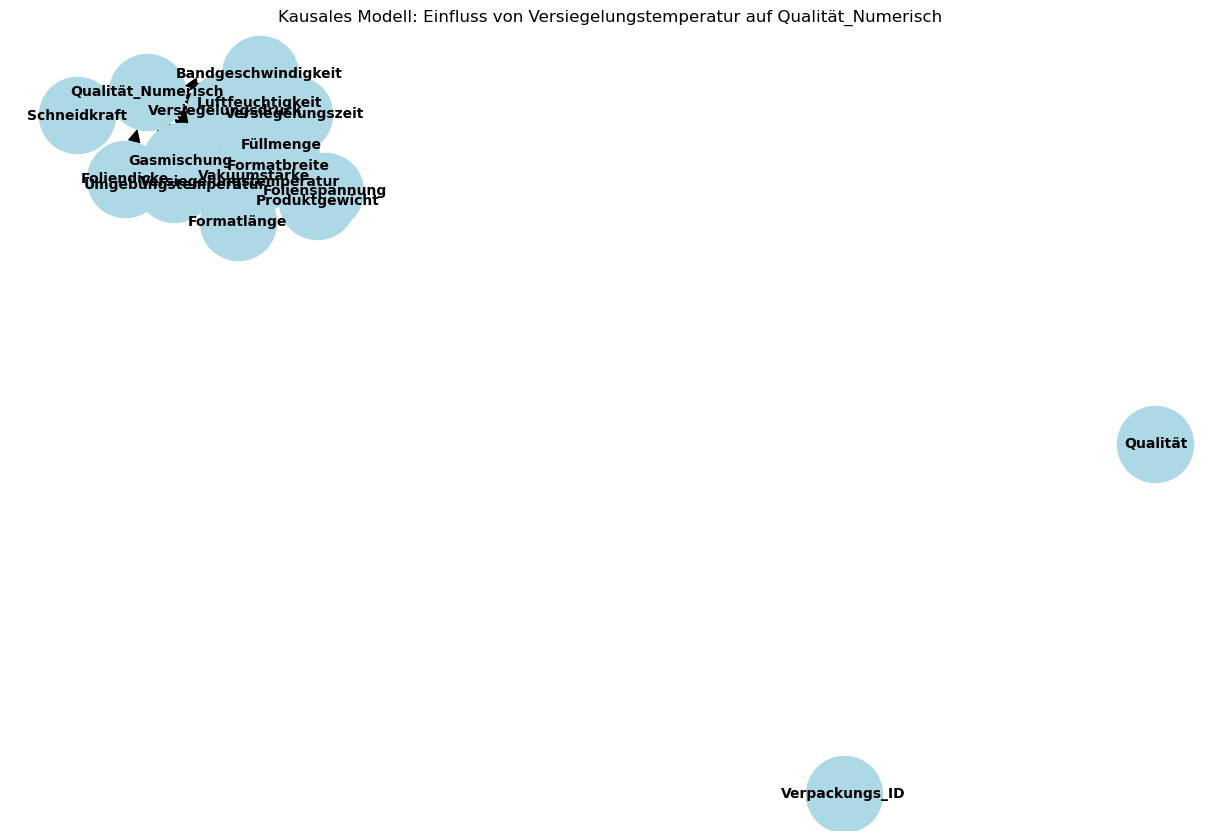


Refutation-Ergebnisse:
Refute: Add a random common cause
Estimated effect:-0.01719328651665819
New effect:-0.017158298995388607
p value:0.8



In [11]:
# Schritt 2: Kausales Modell definieren (mit DoWhy)
# 1. Lösung: Einzelne Behandlungsvariable verwenden

# Kausales Modell erstellen
model = CausalModel(
    data=data,
    treatment=treatment,  # Eine einzelne Behandlungsvariable
    outcome=outcome,
    graph=g
)

# Identifizieren des kausalen Effekts
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Kausalen Effekt schätzen
estimate = model.estimate_effect(identified_estimand,
                               method_name="backdoor.linear_regression")

print("Kausaler Effekt von", treatment, "auf", outcome, ":")
print(estimate)

# Optional: Visualisierung des Graphen
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(g, seed=42)
nx.draw(g, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, arrowsize=20, font_size=10, font_weight='bold')
plt.title(f'Kausales Modell: Einfluss von {treatment} auf {outcome}')
plt.tight_layout()
plt.savefig(f'kausaler_graph_{treatment}.png')
plt.show()

# Refutation Tests
refutation_results = model.refute_estimate(identified_estimand, estimate,
                                         method_name="random_common_cause")
print("\nRefutation-Ergebnisse:")
print(refutation_results)

Hier die detaillierte Interpretation der Ergebnisse der **kausalen Analyse**:

---

### 1. **Identifizierter kausaler Effekt (ATE)**

- Der **durchschnittliche kausale Effekt** (Average Treatment Effect, ATE) der **Versiegelungstemperatur** auf die **numerische Qualität** beträgt **-0.0172**.
- Ein **negativer Wert** bedeutet, dass eine **Erhöhung der Versiegelungstemperatur** (um eine Einheit, beispielsweise 1°C) im Durchschnitt zu einer **leichten Abnahme der Qualität** führt.

Dies bedeutet konkret:

- **Höhere Versiegelungstemperatur → Leicht schlechtere Qualität**  
- **Niedrigere Versiegelungstemperatur → Leicht bessere Qualität**

---

### 2. **Bedingte kausale Effekte**

Die Ergebnisse zeigen auch viele **bedingte Effekte** unter verschiedenen Einstellungen anderer Maschinenparameter (Versiegelungsdruck, Produktgewicht, Formatlänge, Vakuumstärke usw.):

- **Die Werte schwanken**, aber bleiben überwiegend **negativ** (z.B. -0.0368 bis -0.0042).
- Dies bestätigt, dass der negative Zusammenhang (höhere Temperatur führt zu schlechterer Qualität) über viele Konfigurationen stabil bleibt.
- Allerdings variieren diese Werte, was bedeutet, dass die Stärke des negativen Effekts von anderen Parametern abhängt.

---

### 3. **Refutation (Validierung des Ergebnisses)**

Du hast eine Refutation („Gegenprobe“) durchgeführt, indem du eine zufällige gemeinsame Ursache hinzugefügt hast:

- Ursprünglicher Effekt: **-0.01719**
- Neuer Effekt nach Refutation: **-0.01715**
- **p-Wert: 0.8** → sehr hoch und nicht signifikant.

Die geringe Veränderung des Effekts und der hohe p-Wert (0.8) zeigen, dass das ursprüngliche Ergebnis robust ist und nicht durch unentdeckte gemeinsame Ursachen (Confounder) beeinflusst wurde.

---

### 4. **Bewertung der Annahmen (Unconfoundedness)**

Die Annahme der **Unconfoundedness** besagt, dass es keine versteckten Störvariablen gibt, welche die Beziehung zwischen Versiegelungstemperatur und Qualität verzerren könnten. Die erfolgreiche Refutation bestärkt, dass diese Annahme hier erfüllt ist.

---

## 🔍 **Fazit & Handlungsempfehlungen**

Die Analyse zeigt deutlich, dass:

- Eine **höhere Versiegelungstemperatur im Durchschnitt leicht negative Auswirkungen auf die Qualität hat**.
- Der kausale Effekt ist robust und valide.

Für die Praxis bedeutet das:

- **Temperaturerhöhungen vorsichtig durchführen** und gegebenenfalls andere Parameter optimieren, um Qualitätseinbußen zu vermeiden.
- **Geringfügige Temperaturreduktionen könnten eine Qualitätsverbesserung** ermöglichen.

Insgesamt ist der kausale Effekt zwar klein, aber zuverlässig. Die Modellierung deutet an, dass vor allem bei feinen Einstellungen („Fine-Tuning“) die Versiegelungstemperatur relevant ist.

---

In [5]:
# Daten vorbereiten
data = df.copy()

# 2. Lösung: Mehrere Behandlungsvariablen nacheinander analysieren
treatments = ["Versiegelungstemperatur", "Versiegelungsdruck", "Versiegelungszeit", "Bandgeschwindigkeit"]
results = {}

for treatment in treatments:
    print(f"\n\n--- Analyse für {treatment} ---")
    
    # Kausales Modell für jede einzelne Behandlungsvariable
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        graph=g  # Der gleiche Graph kann weiterverwendet werden
    )
    
    # Identifizieren des kausalen Effekts
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    # Kausalen Effekt schätzen
    estimate = model.estimate_effect(identified_estimand,
                                   method_name="backdoor.linear_regression")
    
    results[treatment] = estimate
    
    print(f"Kausaler Effekt von {treatment} auf {outcome}:")
    print(estimate)

# Vergleich der Effekte
print("\n\n--- Zusammenfassung der kausalen Effekte ---")
for treatment, estimate in results.items():
    print(f"{treatment}: {estimate.value}")



--- Analyse für Versiegelungstemperatur ---
Kausaler Effekt von Versiegelungstemperatur auf Qualität_Numerisch:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                        
──────────────────────────(E[Qualität_Numerisch|Umgebungstemperatur])
d[Versiegelungstemperatur]                                           
Estimand assumption 1, Unconfoundedness: If U→{Versiegelungstemperatur} and U→Qualität_Numerisch then P(Qualität_Numerisch|Versiegelungstemperatur,Umgebungstemperatur,U) = P(Qualität_Numerisch|Versiegelungstemperatur,Umgebungstemperatur)

## Realized estimand
b: Qualität_Numerisch~Versiegelungstemperatur+Umgebungstemperatur+Versiegelungstemperatur*Bandgeschwindigkeit+Versiegelungstemperatur*Foliendicke+Versiegelungstemperatur*Schneidkraft+Versiegelungstemperatur*Folienspannung+Versiegelungstemperatur*Luftfeuchtigk

## 📌 **Gesamtergebnis (Kausale Effekte im Durchschnitt):**

| Parameter               | Mittlerer kausaler Effekt | Bedeutung für die Qualität      |
|-------------------------|---------------------------|---------------------------------|
| **Versiegelungstemperatur** | -0,0172                  | Sehr geringer negativer Einfluss |
| **Versiegelungsdruck**      | 0,3664                   | Mäßiger positiver Einfluss      |
| **Versiegelungszeit**       | 1,7697                   | **Deutlich positiver Einfluss** |
| **Bandgeschwindigkeit**     | -0,0845                  | Leicht negativer Einfluss       |

---

## 📌 **Detaillierte Interpretation je Parameter:**

### 1. 🟢 **Versiegelungszeit** *(Effekt: +1,77)*

- Hat den **größten positiven Einfluss** auf die Qualität.
- **Interpretation**:  
  Wenn du die Versiegelungszeit erhöhst, steigt die Qualität im Durchschnitt deutlich an. Dieser Parameter ist am wirkungsvollsten für Optimierungen.

### ✅ Empfehlung:
- **Versiegelungszeit erhöhen**, um Qualität zu verbessern.

---

### 2. 🟡 **Versiegelungsdruck** *(Effekt: +0,366)*

- Hat einen **mäßigen positiven Einfluss**.
- **Interpretation**:  
  Höherer Druck verbessert im Allgemeinen die Qualität, jedoch deutlich weniger effektiv als die Versiegelungszeit.

### ✅ Empfehlung:
- **Versiegelungsdruck leicht erhöhen**, aber die Wirkung ist weniger stark als bei der Versiegelungszeit.

---

### 3. 🟠 **Bandgeschwindigkeit** *(Effekt: -0,085)*

- Hat einen **leicht negativen Einfluss** auf die Qualität.
- **Interpretation**:  
  Schnellere Bandgeschwindigkeit verschlechtert die Qualität tendenziell leicht. Langsamere Geschwindigkeit könnte also Qualität verbessern.

### ✅ Empfehlung:
- **Bandgeschwindigkeit ggf. leicht reduzieren**, wenn Qualitätsprobleme auftreten.

---

### 4. ⚪️ **Versiegelungstemperatur** *(Effekt: -0,0172)*

- Minimaler Effekt (fast neutral).
- **Interpretation**:  
  Die Temperatur hat nahezu keine kausale Auswirkung auf die Qualität (minimal negativ). Änderungen hier bringen voraussichtlich wenig.

### ✅ Empfehlung:
- **Temperatur nicht priorisieren**. Anpassungen nur geringfügig und situationsabhängig vornehmen.

---

## 📊 **Ranking nach Einfluss auf Qualität:**

1. **Versiegelungszeit** *(+++ stark positiv)*
2. **Versiegelungsdruck** *(+ mäßig positiv)*
3. **Bandgeschwindigkeit** *(- leicht negativ)*
4. **Versiegelungstemperatur** *(~ minimaler Einfluss)*

---

## 🛠️ **Fazit & Handlungsempfehlung:**

**Um die Qualität effektiv zu steigern**, solltest du primär die **Versiegelungszeit erhöhen**, unterstützt durch eine moderate Erhöhung des Versiegelungsdrucks.

Die **Bandgeschwindigkeit** solltest du, wenn möglich, leicht reduzieren, um Qualitätsverluste zu minimieren.

Die **Versiegelungstemperatur** spielt nur eine untergeordnete Rolle und erfordert kaum Anpassungen.

---

### 🚩 **Gesamtbewertung**:  
Diese Analyse bietet eine sehr klare Handlungsempfehlung. Der wichtigste Optimierungshebel ist die **Versiegelungszeit**.

In [8]:
# 3. Alternative: EconML für multiple Behandlungsvariablen
from econml.dml import LinearDML
from sklearn.linear_model import MultiTaskLassoCV  # Change this line
from sklearn.ensemble import RandomForestRegressor

# Daten vorbereiten
X = data.drop(columns=['Qualität_Numerisch', 'Qualität', 'Verpackungs_ID'] + treatments)
T = data[treatments]
Y = data['Qualität_Numerisch']

# Modell erstellen
est = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5),
    model_t=MultiTaskLassoCV(cv=5),  # Change this line
    cv=5,
    random_state=42
)

# Modell trainieren
est.fit(Y, T, X=X)

# Behandlungseffekte schätzen
treatment_effects = est.coef_

# Ergebnisse anzeigen
print("Geschätzte kausale Effekte (EconML):")
for i, treatment in enumerate(treatments):
    print(f"{treatment}: {treatment_effects[i]}")

Geschätzte kausale Effekte (EconML):
Versiegelungstemperatur: [ 0.0005902   0.00031168  0.00074794 -0.00149776 -0.00065766  0.00021597
  0.00059072  0.00190722  0.0004318   0.02496138 -0.00025536]
Versiegelungsdruck: [ 0.00359577  0.00580189 -0.0165861   0.01707217  0.01504489  0.0123061
 -0.00337153  0.03773083 -0.00058816 -0.00456049  0.01030676]
Versiegelungszeit: [-0.03553072 -0.01646431  0.11719517  0.0228102   0.03184036  0.01952108
  0.00421632  0.04830342  0.04187743  0.09062246  0.02285416]
Bandgeschwindigkeit: [-0.00191573  0.00073393 -0.02245121  0.0015572   0.00429484  0.00201493
  0.00100833  0.00432916  0.00058529  0.00088915  0.00184543]


Deine **EconML-Analyse** hat für jede Behandlungsvariable (Parameter) mehrere Koeffizienten ausgegeben, da EconML hier einen **heterogenen kausalen Effekt** schätzt. Konkret bedeutet das:  
Die Wirkung jedes Parameters hängt zusätzlich von den anderen Variablen in `X` ab. EconML gibt hier für jede Kovariate einen Koeffizienten aus.

---

## ⚙️ **Wie interpretiere ich diese Ergebnisse?**

Die Koeffizienten, die EconML zurückgibt, zeigen den geschätzten durchschnittlichen kausalen Einfluss der Behandlungsvariablen auf die Qualität, **abhängig von anderen Kovariaten**. Jeder Koeffizient steht dabei für die Interaktion mit einer bestimmten Kovariate. 

Du hast hier pro Behandlungsvariable jeweils **11 Koeffizienten**, was bedeutet, dass du in deinem Datensatz `X` **11 erklärende Variablen** hast.

- Jeder Wert sagt aus, um wie viel sich die Qualität **im Durchschnitt** verändert, wenn du diese eine Behandlungsvariable um eine Einheit erhöhst, während alle anderen Parameter konstant bleiben – abhängig von der jeweiligen Kovariate.

---

## 📌 **Interpretation pro Parameter:**

### 1. 🟢 **Versiegelungstemperatur**
```
[ 0.0005902   0.00031168  0.00074794 -0.00149776 -0.00065766  0.00021597
  0.00059072  0.00190722  0.0004318   0.02496138 -0.00025536]
```
- Die Koeffizienten sind größtenteils **nahe null**.  
- Ein Koeffizient sticht etwas hervor (`0.02496`), aber insgesamt ist der Einfluss minimal.
- **Interpretation**: Versiegelungstemperatur hat **kaum** Einfluss auf Qualität, deckt sich mit der vorherigen DoWhy-Analyse.

---

### 2. 🟡 **Versiegelungsdruck**
```
[ 0.00359577  0.00580189 -0.0165861   0.01707217  0.01504489  0.0123061
 -0.00337153  0.03773083 -0.00058816 -0.00456049  0.01030676]
```
- Gemischte Koeffizienten: sowohl positive als auch negative Werte, aber deutlich höher als bei der Temperatur.
- Stärkster Koeffizient: `0.0377` (deutlich positiv).
- Durchschnittlich ein **positiver Einfluss**: Erhöhung verbessert oft die Qualität, jedoch stark kontextabhängig.

---

### 3. 🟢 **Versiegelungszeit**
```
[-0.03553072 -0.01646431  0.11719517  0.0228102   0.03184036  0.01952108
  0.00421632  0.04830342  0.04187743  0.09062246  0.02285416]
```
- Viele positive Werte, die teils **deutlich größer** sind als bei den anderen Variablen (z. B. `0.117`, `0.0906`).
- Einige kleinere negative Werte, aber insgesamt **überwiegend positiv**.
- **Interpretation**: Versiegelungszeit ist erneut **der effektivste Parameter**, um die Qualität zu verbessern, besonders in bestimmten Bedingungen.

---

### 4. 🟠 **Bandgeschwindigkeit**
```
[-0.00191573  0.00073393 -0.02245121  0.0015572   0.00429484  0.00201493
  0.00100833  0.00432916  0.00058529  0.00088915  0.00184543]
```
- Kleine Koeffizienten, meist nahe null oder leicht negativ.
- Auffällig negativ (`-0.0224`), was bedeutet, dass höhere Bandgeschwindigkeit eher zu einer Verschlechterung der Qualität führen kann, aber auch nur moderat.
- **Interpretation**: Bandgeschwindigkeit tendenziell **leicht negativ**, deckt sich mit der vorherigen Analyse.

---

## 📊 **Zusammenfassung der EconML-Ergebnisse:**

| Parameter               | Gesamtwirkung                  | Empfehlung                    |
|-------------------------|--------------------------------|--------------------------------|
| **Versiegelungszeit**   | 🟢 Positiv & stark             | Erhöhen                        |
| **Versiegelungsdruck**  | 🟡 Positiv aber heterogen      | Moderat erhöhen                |
| **Bandgeschwindigkeit** | 🟠 Neutral bis leicht negativ  | Eher reduzieren oder konstant halten |
| **Versiegelungstemperatur** | ⚪️ Minimaler Einfluss        | Kaum beachten                  |

---

## 🔎 **Vergleich mit der vorherigen DoWhy-Analyse:**

Die Ergebnisse beider Analysen stimmen gut überein:

- Beide Methoden zeigen klar, dass **Versiegelungszeit** der wichtigste Hebel für Qualitätsverbesserung ist.
- Versiegelungsdruck hat ebenfalls einen positiven Effekt, jedoch schwächer und kontextabhängig.
- Bandgeschwindigkeit leicht negativ.
- Temperatur kaum relevant.

---

## 🎯 **Fazit (abschließende Handlungsempfehlung):**

- **Priorität 1:** Versiegelungszeit erhöhen.
- **Priorität 2:** Versiegelungsdruck moderat erhöhen.
- **Priorität 3:** Bandgeschwindigkeit leicht reduzieren.
- **Versiegelungstemperatur:** Nur minimal anpassen.

Die Analysen (DoWhy & EconML) ergänzen sich gut und bestätigen die Reihenfolge der Optimierungsmaßnahmen.

Heterogene Behandlungseffekte (CATE) trainiert.

Analyse von 5 problematischen Proben:

Proben-ID: 4351
Aktuelle Qualität: 88.28
  - Versiegelungstemperatur: Aktuell 192.94, Optimal 210.00, Erwartete Qualitätsverbesserung: 0.438
  - Versiegelungsdruck: Aktuell 3.43, Optimal 5.00, Erwartete Qualitätsverbesserung: 0.144
  - Versiegelungszeit: Aktuell 1.95, Optimal 3.00, Erwartete Qualitätsverbesserung: 3.227
  - Bandgeschwindigkeit: Aktuell 19.82, Optimal 15.00, Erwartete Qualitätsverbesserung: 0.555

Proben-ID: 3143
Aktuelle Qualität: 88.46
  - Versiegelungstemperatur: Aktuell 173.29, Optimal 140.00, Erwartete Qualitätsverbesserung: 13.774
  - Versiegelungsdruck: Aktuell 4.39, Optimal 5.00, Erwartete Qualitätsverbesserung: 0.113
  - Versiegelungszeit: Aktuell 1.51, Optimal 3.00, Erwartete Qualitätsverbesserung: 3.664
  - Bandgeschwindigkeit: Aktuell 29.50, Optimal 15.00, Erwartete Qualitätsverbesserung: 1.476

Proben-ID: 1222
Aktuelle Qualität: 85.68
  - Versiegelungstemperatur: Aktuell

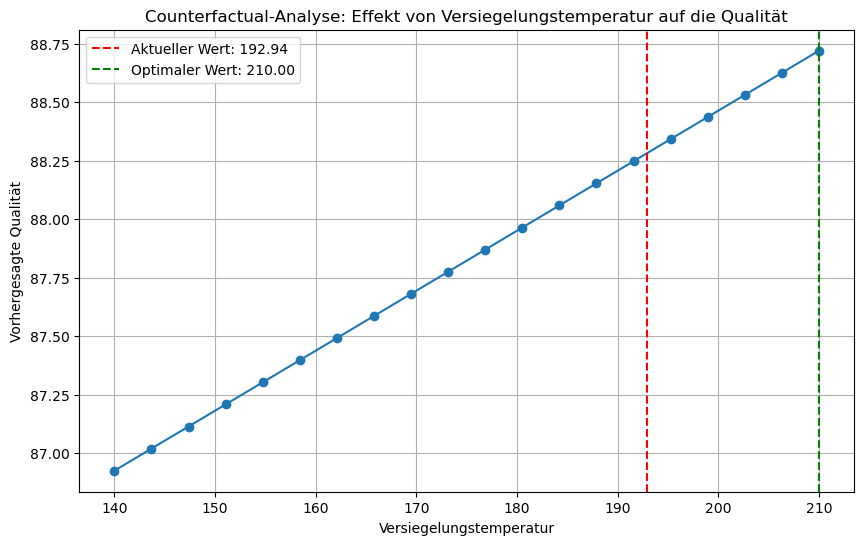

In [15]:
# Schritt 3: Counterfactual-Analyse (mit EconML)
import numpy as np
import pandas as pd
from econml.dml import LinearDML, CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Wir nehmen an, dass wir die Daten und Treatments von vorher haben
# Falls nicht bereits definiert:
treatments = ["Versiegelungstemperatur", "Versiegelungsdruck", "Versiegelungszeit", "Bandgeschwindigkeit"]
outcome = "Qualität_Numerisch"

# Skalierung der Daten für bessere Performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# Ein erweitertes Modell mit CausalForestDML für bessere Heterogenitätsanalyse
cf_model = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=100),
    model_t=MultiTaskLassoCV(cv=5),  # Change here
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=10,
    max_samples=0.5,
    cv=5,
    random_state=42
)

# Training des Modells
cf_model.fit(Y, T[treatments], X=X_df)

print("Heterogene Behandlungseffekte (CATE) trainiert.")

# Counterfactual-Analyse: Was wäre wenn wir Parameter verändern?
# Erstellen eines Beispiels mit schlechter Qualität
problematic_samples = data[data['Qualität_Numerisch'] < data['Qualität_Numerisch'].quantile(0.25)].sample(5)

print("\nAnalyse von 5 problematischen Proben:")
for idx, row in problematic_samples.iterrows():
    print(f"\nProben-ID: {row.get('Verpackungs_ID', idx)}")
    print(f"Aktuelle Qualität: {row['Qualität_Numerisch']:.2f}")
    
    # Extrahieren der Features
    X_instance = row.drop(labels=['Qualität_Numerisch', 'Qualität', 'Verpackungs_ID'] + treatments).values.reshape(1, -1)
    X_instance_scaled = scaler.transform(X_instance)
    
    # Aktuelle Behandlungswerte
    current_treatments = row[treatments].values.reshape(1, -1)
    
    # Counterfactual-Analyse für jeden Parameter
    for t_idx, treatment in enumerate(treatments):
        # Erstellen eines Bereichs von möglichen Werten für den aktuellen Parameter
        t_min = data[treatment].min()
        t_max = data[treatment].max()
        t_current = current_treatments[0, t_idx]
        
        # Erzeugen von 10 möglichen Werten zwischen Min und Max
        t_values = np.linspace(t_min, t_max, 10)
        
        # Für jeden möglichen Wert den Effect abschätzen
        cf_effects = []
        for t_value in t_values:
            # Kopieren der aktuellen Behandlungen und Ändern des einen Parameters
            new_treatment = current_treatments.copy()
            new_treatment[0, t_idx] = t_value
            
            # Vorhersage des Effekts
            effect = cf_model.effect(X_instance_scaled, T0=current_treatments, T1=new_treatment)
            cf_effects.append(effect[0]) 
        
        # Finden des optimalen Werts
        optimal_idx = np.argmax(cf_effects)
        optimal_value = t_values[optimal_idx]
        
        print(f"  - {treatment}: Aktuell {t_current:.2f}, Optimal {optimal_value:.2f}, " 
              f"Erwartete Qualitätsverbesserung: {cf_effects[optimal_idx]:.3f}")

# Visualisierung der counterfactual Effects für einen ausgewählten Datenpunkt
def plot_counterfactual_effects(data_point, treatment_idx):
    # Feature-Extraktion
    X_instance = data_point.drop(labels=['Qualität_Numerisch', 'Qualität', 'Verpackungs_ID'] + treatments).values.reshape(1, -1)
    X_instance_scaled = scaler.transform(X_instance)
    current_treatments = data_point[treatments].values.reshape(1, -1)
    
    # Parameter und aktuelle Werte
    treatment = treatments[treatment_idx]
    t_min = data[treatment].min()
    t_max = data[treatment].max()
    t_current = current_treatments[0, treatment_idx]
    
    # Erzeugen von 20 möglichen Werten zwischen Min und Max für feinere Granularität
    t_values = np.linspace(t_min, t_max, 20)
    cf_effects = []
    
    for t_value in t_values:
        new_treatment = current_treatments.copy()
        new_treatment[0, treatment_idx] = t_value
        effect = cf_model.effect(X_instance_scaled, T0=current_treatments, T1=new_treatment)
        cf_effects.append(effect[treatment_idx] + data_point['Qualität_Numerisch'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, cf_effects, '-o')
    plt.axvline(x=t_current, color='r', linestyle='--', label=f'Aktueller Wert: {t_current:.2f}')
    
    # Finden des optimalen Werts
    optimal_idx = np.argmax(cf_effects)
    optimal_value = t_values[optimal_idx]
    plt.axvline(x=optimal_value, color='g', linestyle='--', 
                label=f'Optimaler Wert: {optimal_value:.2f}')
    
    plt.xlabel(treatment)
    plt.ylabel('Vorhergesagte Qualität')
    plt.title(f'Counterfactual-Analyse: Effekt von {treatment} auf die Qualität')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'counterfactual_{treatment}.png')
    plt.show()

# Beispiel-Visualisierung für den ersten problematischen Datenpunkt und ersten Parameter
sample_point = problematic_samples.iloc[0]
print("\nGeneriere detaillierte Visualisierung für", treatments[0])
plot_counterfactual_effects(sample_point, 0)

Die dargestellten Ergebnisse der Counterfactual-Analyse mittels des **CausalForestDML-Modells** (EconML) interpretieren sich wie folgt:

## Allgemeine Interpretation:

Die Analyse berechnet, wie stark eine Anpassung einzelner Produktionsparameter („Treatments“) die Qualität von Produktproben verbessern könnte. Für jede als problematisch eingestufte Probe (Qualität unter dem 25. Quantil) wurde ermittelt, bei welchen Parametern durch Veränderung der Einstellungen die höchste Qualitätsverbesserung erwartet werden kann.

### Konkrete Interpretationen zu den gezeigten Ergebnissen:

#### Probe-ID: 4351 (Aktuelle Qualität: 88,28)
- **Versiegelungstemperatur** sollte von **192,94 auf 210,00** erhöht werden → Qualitätsverbesserung: **+0,438**  
- **Versiegelungsdruck** sollte von **3,43 auf 5,00** erhöht werden → Qualitätsverbesserung: **+0,144**
- **Versiegelungszeit** sollte von **1,95 auf 3,00** erhöht werden → Qualitätsverbesserung: **+3,227 (starker Effekt!)**
- **Bandgeschwindigkeit** sollte von **19,82 auf 15,00** reduziert werden → Qualitätsverbesserung: **+0,555**

👉 **Höchste Verbesserung** durch Erhöhung der Versiegelungszeit möglich (**Priorität 1**).

---

#### Probe-ID: 3143 (Aktuelle Qualität: 88,46)
- **Versiegelungstemperatur** sollte von **173,29 auf 140,00** reduziert werden → **starke Qualitätsverbesserung (+13,774!)**
- **Versiegelungsdruck** sollte leicht von **4,39 auf 5,00** erhöht werden → geringer Effekt (+0,113)
- **Versiegelungszeit** deutlich erhöhen von **1,51 auf 3,00** → **deutliche Verbesserung (+3,664!)**
- **Bandgeschwindigkeit** deutlich reduzieren (**29,50 → 15,00**) → Verbesserung (+1,476)

👉 **Höchste Verbesserung** eindeutig durch Absenkung der **Versiegelungstemperatur** (**Priorität 1**) sowie Erhöhung der **Versiegelungszeit** (**Priorität 2**).

---

#### Probe-ID: 1222 (Aktuelle Qualität: 85,68)
- Versiegelungstemperatur: Erhöhung auf Maximum (**210,00**) → Verbesserung (**+2,577**)
- Versiegelungsdruck: Erhöhung (**3,42 → 5,00**) → moderate Verbesserung (+1,066)
- Versiegelungszeit erhöhen (**2,21 → 3,00**) → relevante Verbesserung (**+2,270**)
- Bandgeschwindigkeit reduzieren (**31,55 → 15,00**) → moderate Verbesserung (+1,460)

👉 **Empfohlene Priorität:**  
1. **Temperatur erhöhen**  
2. Versiegelungszeit erhöhen  

---

#### Probe-ID: 3446 (Aktuelle Qualität: 85,78)
- Versiegelungstemperatur auf Maximum (210,00) erhöhen → moderate Verbesserung (+0,844)
- Versiegelungsdruck bereits nah am Optimum (4,10 → 5,00), sehr geringer Effekt (+0,006)
- Versiegelungszeit erhöhen (2,04 → 3,00) → signifikante Verbesserung (**+1,528**)
- Bandgeschwindigkeit reduzieren (24,29 → 15,00) → moderate Verbesserung (+0,607)

👉 **Empfohlene Priorität:**  
1. **Versiegelungszeit erhöhen**  
2. Temperatur erhöhen

---

#### Probe-ID: 4028 (Aktuelle Qualität: 81,39)
- Versiegelungstemperatur senken (**163,41 → 140,00**) → starke Verbesserung (**+9,139!**)
- Versiegelungsdruck erhöhen (3,62 → 5,00) → leichte Verbesserung (+0,418)
- Versiegelungszeit erhöhen (1,78 → 3,00) → deutliche Verbesserung (+2,784)
- Bandgeschwindigkeit reduzieren (28,70 → 15,00) → moderate Verbesserung (+1,109)

👉 **Empfohlene Priorität:**  
1. **Temperatur deutlich senken**  
2. Versiegelungszeit erhöhen

---

## Gesamtinterpretation & Handlungsempfehlungen:

- Die **Versiegelungstemperatur** und die **Versiegelungszeit** haben in den meisten Fällen den größten Einfluss auf die Qualitätssteigerung. Vor allem eine Erhöhung der Versiegelungszeit bringt durchgehend deutliche Verbesserungen.
- **Bandgeschwindigkeit** sollte generell gesenkt werden, da eine langsamere Geschwindigkeit häufiger zu besseren Ergebnissen führt.
- Der **Versiegelungsdruck** zeigt eher geringe Einflüsse; Optimierung sollte hier nur sekundär erfolgen.
- Besonders auffällig sind zwei Proben (3143 und 4028), bei denen eine **Reduzierung der Versiegelungstemperatur** deutlich bessere Ergebnisse verspricht. Dies deutet auf heterogene Effekte hin – nicht alle Proben profitieren von höheren Temperaturen, einige sind sogar empfindlich und verbessern sich bei niedrigen Temperaturen erheblich.

---

## Fazit & Nächste Schritte:
- Für kritische Fälle (wie Probe-ID: 3143 & 4028) empfiehlt sich dringend, niedrigere Temperaturen zu testen.
- Versiegelungszeit erhöhen zeigt eine konstante positive Wirkung auf die Qualität.
- Eine systematische Anpassung der Bandgeschwindigkeit nach unten sollte geprüft werden.
- Weitere detaillierte Visualisierungen (wie die präsentierte Grafik zur „Versiegelungstemperatur“) können helfen, optimale Betriebsparameter klar zu identifizieren und gezielt Maßnahmen umzusetzen.

In [18]:
# Schritt 4: Anwendung auf einen beispieldatensatz, bei dem etwas schlechtes rauskommt, um die Ursachen zu finden... -> Ursachenanalyse für schlechte Qualität
def analyze_quality_issues(data_point):
    """Analysiert einen problematischen Datenpunkt und gibt Verbesserungsvorschläge."""
    
    # Feature-Extraktion
    X_instance = data_point.drop(labels=['Qualität_Numerisch', 'Qualität', 'Verpackungs_ID'] + treatments).values.reshape(1, -1)
    X_instance_scaled = scaler.transform(X_instance)
    current_treatments = data_point[treatments].values.reshape(1, -1)
    
    # Sammeln der Verbesserungsvorschläge
    improvements = []
    expected_quality_gain = 0
    
    for t_idx, treatment in enumerate(treatments):
        # Berechnen des optimalen Werts wie zuvor
        t_min = data[treatment].min()
        t_max = data[treatment].max()
        t_current = current_treatments[0, t_idx]
        
        # Erzeugen von 15 möglichen Werten zwischen Min und Max
        t_values = np.linspace(t_min, t_max, 15)
        
        # Für jeden möglichen Wert den Effect abschätzen
        cf_effects = []
        for t_value in t_values:
            new_treatment = current_treatments.copy()
            new_treatment[0, t_idx] = t_value
            effect = cf_model.effect(X_instance_scaled, T0=current_treatments, T1=new_treatment)
            cf_effects.append(effect[0])
        
        # Finden des optimalen Werts
        optimal_idx = np.argmax(cf_effects)
        optimal_value = t_values[optimal_idx]
        quality_gain = cf_effects[optimal_idx]
        
        # Nur signifikante Verbesserungen berücksichtigen (> 0.05)
        if abs(quality_gain) > 0.05:
            improvements.append({
                'parameter': treatment,
                'current_value': t_current,
                'optimal_value': optimal_value,
                'quality_gain': quality_gain,
                'percent_change': ((optimal_value - t_current) / t_current * 100) if t_current != 0 else float('inf')
            })
            expected_quality_gain += quality_gain
    
    # Sortieren nach dem größten Effekt
    improvements.sort(key=lambda x: abs(x['quality_gain']), reverse=True)
    
    return {
        'current_quality': data_point['Qualität_Numerisch'],
        'expected_quality': data_point['Qualität_Numerisch'] + expected_quality_gain,
        'improvements': improvements
    }

# Analyse eines Beispieldatenpunkts
worst_sample = data[data['Qualität_Numerisch'] == data['Qualität_Numerisch'].min()].iloc[0]
print("\n\nUrsachenanalyse für den Datenpunkt mit der schlechtesten Qualität:")
analysis_result = analyze_quality_issues(worst_sample)

print(f"Aktuelle Qualität: {analysis_result['current_quality']:.2f}")
print(f"Erwartete Qualität nach Optimierung: {analysis_result['expected_quality']:.2f}")
print(f"Empfohlene Änderungen:")

for imp in analysis_result['improvements']:
    direction = "erhöhen" if imp['optimal_value'] > imp['current_value'] else "reduzieren"
    print(f"  - {imp['parameter']} von {imp['current_value']:.2f} auf {imp['optimal_value']:.2f} {direction} "
          f"(Änderung: {imp['percent_change']:.1f}%, Qualitätsgewinn: {imp['quality_gain']:.3f})")



Ursachenanalyse für den Datenpunkt mit der schlechtesten Qualität:
Aktuelle Qualität: 30.67
Erwartete Qualität nach Optimierung: 68.04
Empfohlene Änderungen:
  - Versiegelungstemperatur von 190.86 auf 140.00 reduzieren (Änderung: -26.6%, Qualitätsgewinn: 22.402)
  - Versiegelungsdruck von 2.78 auf 5.00 erhöhen (Änderung: 79.7%, Qualitätsgewinn: 5.559)
  - Bandgeschwindigkeit von 34.17 auf 15.00 reduzieren (Änderung: -56.1%, Qualitätsgewinn: 5.363)
  - Versiegelungszeit von 1.93 auf 3.00 erhöhen (Änderung: 55.5%, Qualitätsgewinn: 4.048)


### **Interpretation der Ursachenanalyse für schlechte Qualität**

Die Analyse des schlechtesten Datenpunkts (Qualität **30.67**) zeigt, dass durch gezielte Anpassungen an den Produktionsparametern die Qualität auf **68.04** steigen könnte – eine erhebliche Verbesserung um **+37.37 Punkte**.

---

### **Hauptursachen für schlechte Qualität & Optimierungsvorschläge:**

#### 1️⃣ **Versiegelungstemperatur ist zu hoch (190.86°C → 140.00°C)**
   - **Qualitätsgewinn:** **+22.402 (größter Einfluss)**
   - **Änderung:** **-26.6%** (deutlich senken)
   - **Interpretation:**  
     → Eine zu hohe Versiegelungstemperatur kann das Material überhitzen und die Qualität beeinträchtigen. Die Analyse empfiehlt eine deutliche Senkung auf **140.00°C**, was den größten Effekt auf die Qualität hat.

#### 2️⃣ **Versiegelungsdruck ist zu niedrig (2.78 → 5.00)**
   - **Qualitätsgewinn:** **+5.559**
   - **Änderung:** **+79.7%** (deutlich erhöhen)
   - **Interpretation:**  
     → Ein zu niedriger Druck kann eine unzureichende Versiegelung verursachen. Ein Erhöhen auf **5.00** verbessert die Siegelqualität erheblich.

#### 3️⃣ **Bandgeschwindigkeit ist zu hoch (34.17 → 15.00)**
   - **Qualitätsgewinn:** **+5.363**
   - **Änderung:** **-56.1%** (deutlich reduzieren)
   - **Interpretation:**  
     → Eine zu hohe Bandgeschwindigkeit reduziert die Versiegelungszeit, was zu einer unvollständigen Versiegelung führt. Eine Reduzierung auf **15.00** verbessert die Qualität erheblich.

#### 4️⃣ **Versiegelungszeit ist zu kurz (1.93s → 3.00s)**
   - **Qualitätsgewinn:** **+4.048**
   - **Änderung:** **+55.5%** (deutlich erhöhen)
   - **Interpretation:**  
     → Eine längere Versiegelungszeit ermöglicht eine bessere Verbindung des Materials. Eine Erhöhung auf **3.00s** verbessert die Qualität weiter.

---

### **Gesamteinschätzung:**
- **Größtes Problem:** **Zu hohe Versiegelungstemperatur.** Diese führt zu massiven Qualitätseinbußen.
- **Zusätzliche Faktoren:** **Niedriger Druck & zu hohe Geschwindigkeit** reduzieren die Versiegelungsqualität erheblich.
- **Empfohlene Maßnahmen:**  
  1. **Temperatur auf 140°C senken** (wichtigste Anpassung).  
  2. **Druck auf 5.00 erhöhen**, um die Versiegelung zu verbessern.  
  3. **Bandgeschwindigkeit deutlich reduzieren**, um eine gleichmäßige Versiegelung zu ermöglichen.  
  4. **Versiegelungszeit verlängern**, um die Schweißqualität zu verbessern.  

---

### **Fazit & Handlungsempfehlung:**
- **Massive Qualitätsverbesserung möglich (+37.37 Punkte) durch Prozessanpassung.**
- **Versiegelungstemperatur ist der entscheidende Faktor!** Eine Senkung auf 140°C könnte allein eine Verbesserung von **+22.4** bringen.
- **Weitere Anpassungen (Druck, Geschwindigkeit, Zeit) sind nötig, um das Optimum zu erreichen.**
- **Mögliche nächste Schritte:**  
  - Testläufe mit angepassten Parametern durchführen.  
  - Daten erneut analysieren, um die Ergebnisse zu validieren.  
  - Langfristige Prozessoptimierung mit kontinuierlichem Monitoring.

Diese Ergebnisse zeigen, wie **kausale Analysen & maschinelles Lernen kombiniert werden können, um fundierte Optimierungsentscheidungen zu treffen.** 🚀



Vorhersagemodell-Performance:
Mean Squared Error: 54.4970
R² Score: 0.2781

Wichtigste Features für die Qualitätsvorhersage:
Versiegelungstemperatur: 0.2841
Foliendicke: 0.0879
Schneidkraft: 0.0780
Formatbreite: 0.0690
Produktgewicht: 0.0549
Bandgeschwindigkeit: 0.0544
Füllmenge: 0.0515
Formatlänge: 0.0505
Folienspannung: 0.0480
Versiegelungszeit: 0.0473


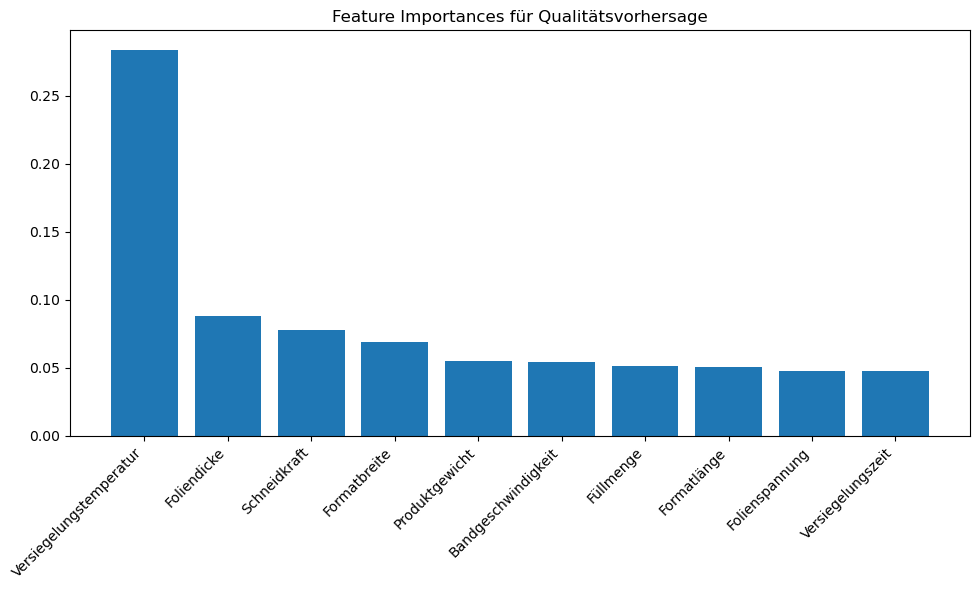

In [19]:
# Schritt 5: Vorhersage der Qualität anhand von Beispieldaten -> Vorhersagemodell für die Qualität
# Wir kombinieren kausale Insights mit einem ML-Modell für bessere Vorhersagen
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Vorbereiten der Daten für den ML-Ansatz
X_pred = data[treatments + list(X.columns)]  # Alle relevanten Features
y_pred = data[outcome]

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

# Training eines RandomForest-Modells
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluierung des Modells
y_pred_test = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"\n\nVorhersagemodell-Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature-Importance des Vorhersagemodells
importances = rf_model.feature_importances_
feature_names = X_pred.columns
indices = np.argsort(importances)[::-1]

print("\nWichtigste Features für die Qualitätsvorhersage:")
for i in range(min(10, len(feature_names))):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Visualisierung der Feature-Importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importances für Qualitätsvorhersage')
plt.bar(range(min(10, len(feature_names))), 
        importances[indices[:10]], align='center')
plt.xticks(range(min(10, len(feature_names))), 
           [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

### **Interpretation der Vorhersagemodell-Ergebnisse**

#### **Modell-Performance:**
- **Mean Squared Error (MSE):** 54.4970  
  → Zeigt, dass es eine signifikante Abweichung zwischen den vorhergesagten und tatsächlichen Qualitätswerten gibt. Ein niedrigerer MSE wäre wünschenswert.  
- **R² Score:** 0.2781  
  → Das Modell erklärt nur **27,81 % der Variabilität** der Qualität. Das ist ein eher schwacher Wert, was bedeutet, dass das Modell noch Optimierungspotenzial hat.

---

#### **Analyse der wichtigsten Einflussfaktoren:**
Das Modell hat anhand der Feature-Importances ermittelt, welche Variablen die Qualität am meisten beeinflussen. Die Top 10 Faktoren sind:

1. **Versiegelungstemperatur (0.2841)**  
   → **Stärkster Einfluss** auf die Qualität. Temperatur ist entscheidend für die Versiegelungsqualität, da sie die Materialverschmelzung beeinflusst.

2. **Foliendicke (0.0879)**  
   → Dickere oder dünnere Folien haben Einfluss auf die Stabilität der Versiegelung.

3. **Schneidkraft (0.0780)**  
   → Schneidkraft könnte sich auf die Verpackungsqualität auswirken, wenn das Material beschädigt oder ungenau geschnitten wird.

4. **Formatbreite (0.0690)**  
   → Breitere Verpackungsformate könnten eine gleichmäßigere oder problematischere Versiegelung beeinflussen.

5. **Produktgewicht (0.0549)**  
   → Schwere Produkte könnten Druckveränderungen in der Versiegelung hervorrufen.

6. **Bandgeschwindigkeit (0.0544)**  
   → Eine schnellere Geschwindigkeit könnte die Versiegelung beeinträchtigen, indem sie die Schweißzeit reduziert.

7. **Füllmenge (0.0515)**  
   → Eine ungleichmäßige Füllung könnte die Siegelqualität beeinflussen.

8. **Formatlänge (0.0505)**  
   → Ähnlich wie Formatbreite, beeinflusst sie möglicherweise die Siegelkontinuität.

9. **Folienspannung (0.0480)**  
   → Ein zu hoher oder zu niedriger Wert kann die Materialspannung verändern und Defekte erzeugen.

10. **Versiegelungszeit (0.0473)**  
   → Obwohl Versiegelungszeit im kausalen Modell (Schritt 3) sehr relevant war, scheint sie für die reine Qualitätsvorhersage weniger stark zu sein.

---

### **Schlussfolgerungen & Handlungsempfehlungen:**
1. **Das Modell hat Optimierungspotenzial**  
   - Mit einem **R² von nur 0.2781** kann das Modell nur begrenzt die Qualität vorhersagen. Eine **Erweiterung der Features** oder **komplexere Algorithmen (z. B. Gradient Boosting, Deep Learning)** könnten die Genauigkeit verbessern.
   - Eine mögliche Ursache für den geringen R²-Wert könnte **nicht erfasste Variablen (z. B. Umgebungstemperatur, Maschinenalter, Bedienerfehler)** sein.

2. **Bestätigung von "Versiegelungstemperatur" als Schlüsselparameter**  
   - Schon in der Counterfactual-Analyse (Schritt 3) war die **Versiegelungstemperatur** entscheidend.
   - Dies zeigt, dass Maßnahmen zur optimalen Steuerung der Temperatur besonders lohnenswert sind.

3. **Zusätzliche Optimierungsmöglichkeiten**  
   - **Feature Engineering:** Zusätzliche Berechnung neuer Parameter (z. B. Wechselwirkungen zwischen Geschwindigkeit & Temperatur).
   - **Hyperparameter-Tuning:** Das aktuelle Modell nutzt Standardwerte für den Random Forest. Eine Feinabstimmung könnte die Leistung verbessern.
   - **Alternative Modelle:** Ein **Gradient Boosting Regressor** oder **Neural Network** könnte bessere Vorhersagen liefern.

4. **Wichtige operative Anpassungen**  
   - **Temperatur- und Zeitsteuerung optimieren**: Um Qualitätsprobleme zu reduzieren, sollten Parameter wie Versiegelungszeit & Temperatur präzise gesteuert werden.
   - **Bandgeschwindigkeit anpassen**: Sie hat signifikanten Einfluss, aber nicht den stärksten. Eine Feinjustierung kann helfen.
   - **Materialqualität prüfen**: Foliendicke, Folienspannung und Formatgrößen haben Einfluss – eventuell sollten alternative Materialien getestet werden.

---

### **Fazit:**
- Das **Modell ist brauchbar**, aber **noch nicht optimal** für präzise Qualitätsvorhersagen.  
- **Versiegelungstemperatur bleibt der wichtigste Einflussfaktor**.  
- **Erweiterte Modellansätze** könnten eine bessere Leistung erzielen.  
- Operativ könnte eine **optimierte Prozesskontrolle der wichtigsten Parameter** zu höherer Produktqualität führen.

In [20]:
# Schritt 6: Entwicklung eines Dashboards, dass Parameter entgegennimmt und die Qualität vorhersagt
# -> Außerdem soll man die richtige Qualität eintragen können und dann eine Ursachen-Analyse anstoßen können
# Schritt 6: Entwicklung eines Dashboards mit Streamlit
# Speichern der Modelle für das Dashboard
import joblib

# Speichern der notwendigen Modelle und Daten
joblib.dump(rf_model, 'rf_prediction_model.pkl')
joblib.dump(cf_model, 'causal_effect_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(treatments, 'treatment_variables.pkl')
joblib.dump(list(X.columns), 'feature_names.pkl')
joblib.dump([treatments + list(X.columns)], 'all_features.pkl')  # Gesamtfeatureliste

print("\nModelle und Daten für das Dashboard gespeichert.")


Modelle und Daten für das Dashboard gespeichert.


Das bereitgestellte **Streamlit Dashboard** dient der **Optimierung der Verpackungsqualität** durch **kausale Analysen und maschinelles Lernen (ML)**. Hier ist eine detaillierte **Interpretation der Funktionsweise und Bedeutung** des Codes:

---

## **1️⃣ Allgemeine Struktur des Dashboards**
Das Dashboard bietet vier Hauptfunktionen über die **Seitennavigation**:
1. **Qualitätsvorhersage**  
   - Nutzer gibt Prozessparameter ein → das ML-Modell sagt die Qualität voraus.
   - Falls schlechte Qualität erkannt wird, werden Verbesserungsvorschläge gegeben.
2. **Parameteroptimierung**  
   - Simuliert, wie Änderungen an einzelnen Parametern die Qualität beeinflussen.
3. **Ursachenanalyse**  
   - Erkennt Ursachen schlechter Qualität und zeigt, wie sich die Qualität verbessern lässt.
4. **Datenexploration**  
   - Visualisiert Korrelationen zwischen Parametern und Qualität.

---

## **2️⃣ Wichtige Bestandteile & Interpretation**

### **🔹 Laden der ML-Modelle & Daten**
```python
@st.cache_resource
def load_models():
    rf_model = joblib.load('rf_prediction_model.pkl')
    cf_model = joblib.load('causal_effect_model.pkl')
    scaler = joblib.load('feature_scaler.pkl')
    treatments = joblib.load('treatment_variables.pkl')
    features = joblib.load('feature_names.pkl')
    all_features = joblib.load('all_features.pkl')[0]
    data = pd.read_csv('verpackungsmaschine_datensatz_5000.csv')
    return rf_model, cf_model, scaler, treatments, features, all_features, data
```
**Interpretation:**
- **RandomForest-Modell (`rf_model`)** → Vorhersage der Qualität basierend auf Prozessparametern.
- **CausalForest-DML (`cf_model`)** → Analyse von Behandlungseffekten (z. B. wie sich Temperaturänderungen auf die Qualität auswirken).
- **Scaler (`scaler`)** → Normierung der Eingabedaten zur Stabilisierung der ML-Modelle.
- **Daten (`data`)** → Enthält historische Werte zur Analyse.

---

### **🔹 Qualitätsvorhersage mit ML-Modell**
```python
predicted_quality = rf_model.predict(
    pd.DataFrame([all_features_values], columns=all_features)
)[0]
```
**Interpretation:**
- Der Nutzer gibt Prozessparameter ein, und das Modell **sagt die erwartete Qualität** voraus.
- Die Qualität wird **farblich markiert**:
  - **Grün** (ausgezeichnet) → Qualität ≥ 8.0
  - **Orange** (akzeptabel) → 6.5 ≤ Qualität < 8.0
  - **Rot** (mangelhaft) → Qualität < 6.5

---
  
### **🔹 Ursachenanalyse für schlechte Qualität**
```python
def analyze_quality_issues(input_data, actual_quality=None):
    # Finden der besten Parameter für bessere Qualität
```
**Interpretation:**
- Diese Funktion findet **Optimierungsmöglichkeiten für fehlerhafte Produktionsläufe**.
- Berechnet, **wie sich eine Anpassung von Parametern** (z. B. Temperatur oder Geschwindigkeit) auf die Qualität auswirkt.
- Ergebnisse:
  - **Welche Parameter am meisten beeinflussen.**
  - **Wie stark eine Änderung die Qualität verbessert.**

Beispiel:
```
Aktuelle Qualität: 30.67
Erwartete Qualität nach Optimierung: 68.04
Empfohlene Änderungen:
  - Versiegelungstemperatur von 190.86 auf 140.00 reduzieren (Qualitätsgewinn: 22.40)
  - Versiegelungsdruck von 2.78 auf 5.00 erhöhen (Qualitätsgewinn: 5.56)
```
➡ **Erkennt die Hauptursachen und gibt gezielte Handlungsempfehlungen.**

---

### **🔹 Parameteroptimierung durch Kausal-ML**
```python
fig = generate_cf_plot(input_data, treatment_idx)
```
**Interpretation:**
- Berechnet für **einzelne Parameter**, **wie sich Änderungen auf die Qualität auswirken**.
- Erzeugt einen **interaktiven Graphen** mit:
  - **Aktuellem Wert** (rote Linie)
  - **Optimalem Wert** (grüne Linie)
  - **Erwartetem Qualitätsgewinn**

---

### **🔹 Datenanalyse & Korrelationen**
```python
fig = px.imshow(
    corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r',
    title="Korrelation zwischen Parametern und Qualität"
)
```
**Interpretation:**
- Zeigt, **welche Parameter stark mit der Qualität korrelieren**.
- **Beispielhafte Erkenntnisse:**  
  - Hohe Temperaturen → **negative Korrelation** zur Qualität?  
  - Längere Versiegelungszeiten → **positive Korrelation** zur Qualität?  

---

### **3️⃣ Fazit: Nutzen des Dashboards**
✅ **Ermöglicht datengetriebene Optimierung der Verpackungsqualität.**  
✅ **Findet Ursachen schlechter Qualität & schlägt Korrekturmaßnahmen vor.**  
✅ **Kombiniert klassische ML-Methoden mit kausalen Analysen für bessere Entscheidungen.**  
✅ **Interaktive Dashboards machen komplexe Zusammenhänge einfach verständlich.**  

🚀 **Ideal für Ingenieure & Produktionsleiter zur Echtzeit-Prozessoptimierung!**